In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=4675be516f8f117f94813acb8c1f6c6c653e4042330607e6aa4c5dd8c7e88e63
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")

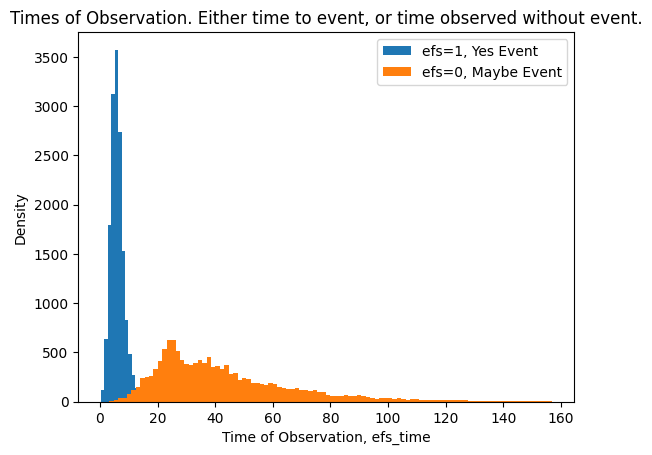

In [3]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

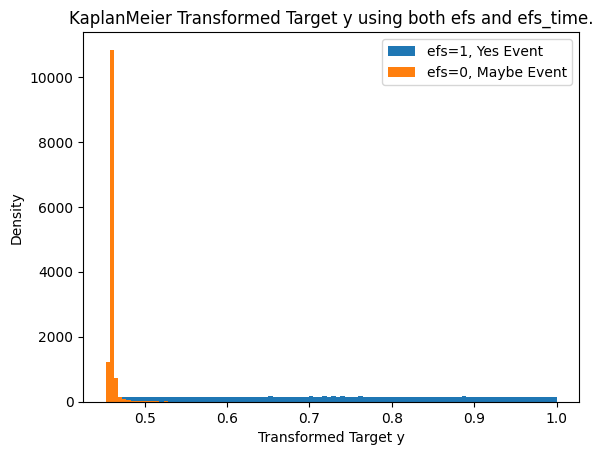

In [4]:
# カプランマイヤーに変換
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    # kmf.fit(生存期間,死亡フラグ)
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y, kmf
train["y"], kmf0 = transform_survival_probability(train, time_col='efs_time', event_col='efs')
plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [5]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [6]:
# カテゴリ変数の分類
CATS = []
for c in FEATURES:
    # オブジェクト場合、欠損はNANを加える
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [7]:
# データ結合
combined = pd.concat([train,test],axis=0,ignore_index=True)

# カテゴリ変数をラベルエンコードする
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # ラベルエンコード
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize() # ラベルエンコード
        combined[c] -= combined[c].min() # ラベルの最小値で引く
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # メモリを減らす(64bit → 32bit)
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

# 訓練データとテストデータに戻す
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [8]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [9]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    # パラメータ
    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        #early_stopping_rounds=25,
    )
    # 訓練
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # 検証データの推論
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # テストデータの推論
    pred_xgb += model_xgb.predict(x_test)

# 推論結果の平均
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17773
[500]	validation_0-rmse:0.15956
[1000]	validation_0-rmse:0.15746
[1500]	validation_0-rmse:0.15650
[1999]	validation_0-rmse:0.15605
#########################
### Fold 2
#########################


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:05:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.17350
[500]	validation_0-rmse:0.15572
[1000]	validation_0-rmse:0.15422
[1500]	validation_0-rmse:0.15356
[1999]	validation_0-rmse:0.15312
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17724
[500]	validation_0-rmse:0.15800
[1000]	validation_0-rmse:0.15612
[1500]	validation_0-rmse:0.15538
[1999]	validation_0-rmse:0.15494
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17923
[500]	validation_0-rmse:0.16024
[1000]	validation_0-rmse:0.15808
[1500]	validation_0-rmse:0.15713
[1999]	validation_0-rmse:0.15668
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17368
[500]	validation_0-rmse:0.15737
[1000]	validation_0-rmse:0.15550
[1500]	validation_0-rmse:0.15474
[1999]	validation_0-rmse:0.15431
#########################
### Fold 6
#########################
[0]	validation_0-rmse:0.17748
[500]	validation_0-rmse:0.15964
[1000]	validation_0-rmse:0.15802
[1500]	va

In [10]:
# スコアへの換算
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier = 0.6737940261928012


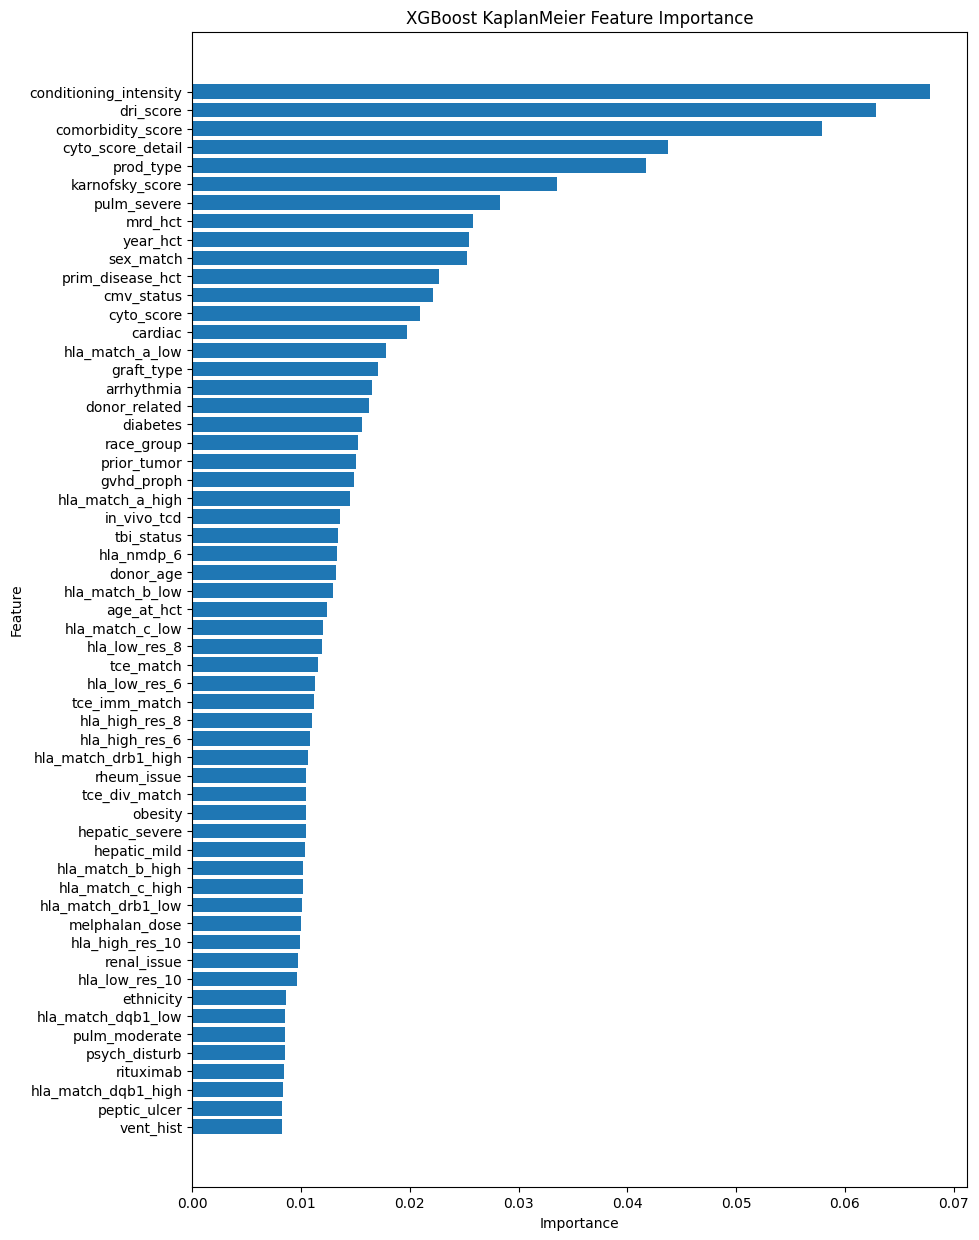

In [11]:
# 特徴量の寄与度
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [12]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [13]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",  
        learning_rate=0.1,    
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1743993	test: 0.1760769	best: 0.1760769 (0)	total: 109ms	remaining: 1m 48s
250:	learn: 0.1444360	test: 0.1574516	best: 0.1573758 (243)	total: 4.9s	remaining: 14.6s
500:	learn: 0.1364002	test: 0.1570436	best: 0.1569415 (486)	total: 9.48s	remaining: 9.44s
750:	learn: 0.1295978	test: 0.1567639	best: 0.1566160 (694)	total: 14s	remaining: 4.63s
999:	learn: 0.1238415	test: 0.1566584	best: 0.1566160 (694)	total: 19s	remaining: 0us
bestTest = 0.1566160111
bestIteration = 694
Shrink model to first 695 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1748674	test: 0.1717315	best: 0.1717315 (0)	total: 21.7ms	remaining: 21.7s
250:	learn: 0.1445834	test: 0.1532805	best: 0.1532805 (250)	total: 5.44s	remaining: 16.2s
500:	learn: 0.1361701	test: 0.1527256	best: 0.1527189 (489)	total: 11.1s	remaining: 11.1s
750:	learn: 0.1297626	test: 0.1529458	best: 0.1526560 (555)	total: 16.7s	remaining: 5

In [14]:
# スコア換算
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier = 0.6740795777257533


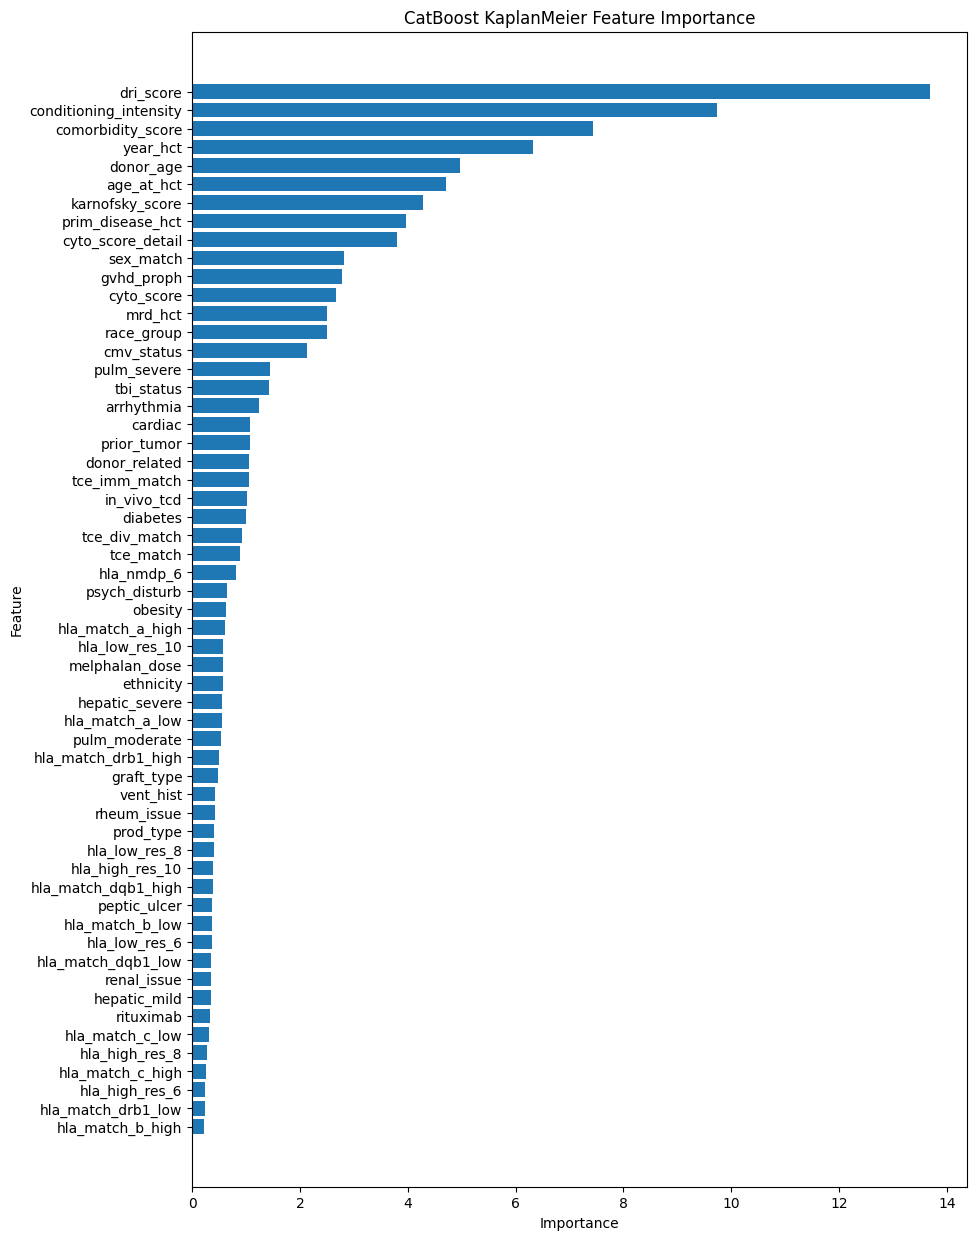

In [15]:
# 特徴量の寄与度
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [16]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
print("Using LightGBM version",lgb.__version__)

Using LightGBM version 4.2.0


In [17]:
# LightGBMのベースライン
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_lgb = LGBMRegressor(
        device="gpu", 
        max_depth=3, 
        colsample_bytree=0.4,  
        #subsample=0.9, 
        n_estimators=2500, 
        learning_rate=0.02, 
        objective="regression", 
        verbose=-1, 
        #early_stopping_rounds=25,
    )
    model_lgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
    )
    
    # INFER OOF
    oof_lgb[test_index] = model_lgb.predict(x_valid)
    # INFER TEST
    pred_lgb += model_lgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_lgb /= FOLDS

#########################
### Fold 1
#########################


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [18]:
# スコアの換算
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for LightGBM KaplanMeier = 0.6725159533961287


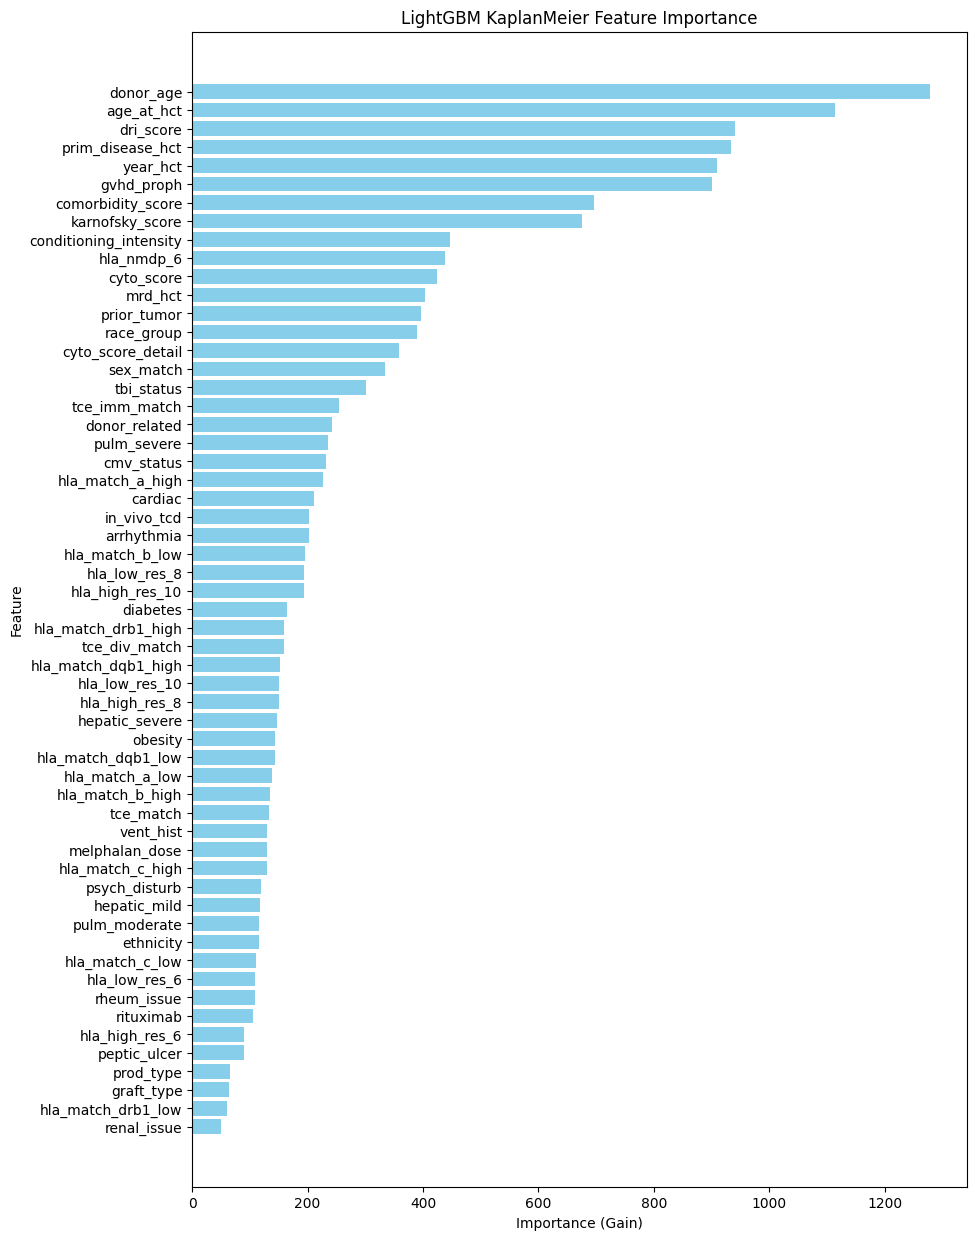

In [19]:
# 特徴量の寄与度
feature_importance = model_lgb.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [20]:
# SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [21]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb_cox = np.zeros(len(train))
pred_xgb_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        objective='survival:cox',
        eval_metric='cox-nloglik',
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500  
    )
    
    # INFER OOF
    oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-cox-nloglik:7.62402
[500]	validation_0-cox-nloglik:7.43513
[1000]	validation_0-cox-nloglik:7.41916
[1500]	validation_0-cox-nloglik:7.41221
[1999]	validation_0-cox-nloglik:7.41085
#########################
### Fold 2
#########################
[0]	validation_0-cox-nloglik:7.61704
[500]	validation_0-cox-nloglik:7.41060
[1000]	validation_0-cox-nloglik:7.39630
[1500]	validation_0-cox-nloglik:7.39059
[1999]	validation_0-cox-nloglik:7.38769
#########################
### Fold 3
#########################
[0]	validation_0-cox-nloglik:7.60952
[500]	validation_0-cox-nloglik:7.40543
[1000]	validation_0-cox-nloglik:7.39056
[1500]	validation_0-cox-nloglik:7.38663
[1999]	validation_0-cox-nloglik:7.38550
#########################
### Fold 4
#########################
[0]	validation_0-cox-nloglik:7.60515
[500]	validation_0-cox-nloglik:7.41071
[1000]	validation_0-cox-nloglik:7.40056
[1500]	validation_0-cox-nloglik:7.39666
[199

In [22]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Survival:Cox = 0.6722446470179296


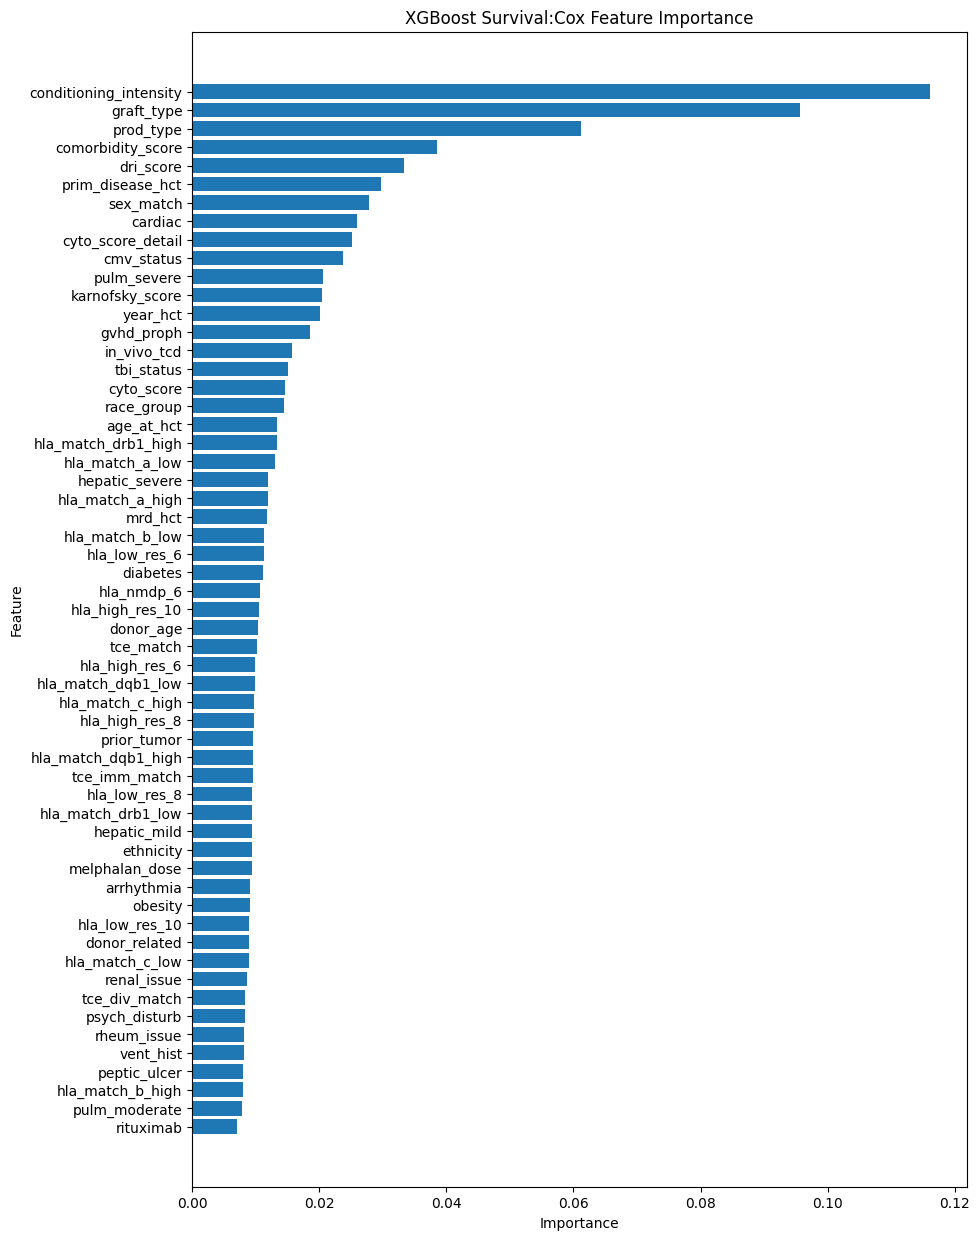

In [23]:
feature_importance = model_xgb_cox.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

### CatBoost (Cox、CV=0.6671)

In [24]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_cox = np.zeros(len(train))
pred_cat_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",   
        iterations=400,     
        learning_rate=0.1,  
        grow_policy='Lossguide',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_cox[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox /= FOLDS

#########################
### Fold 1
#########################
0:	learn: -137204.2010418	test: -11625.0126498	best: -11625.0126498 (0)	total: 73.2ms	remaining: 29.2s
100:	learn: -134245.0940003	test: -11368.0935757	best: -11367.7720241 (99)	total: 6.29s	remaining: 18.6s
200:	learn: -133569.4247640	test: -11357.0053940	best: -11356.8330165 (182)	total: 12.5s	remaining: 12.4s
300:	learn: -133095.7842781	test: -11351.1819262	best: -11351.0222775 (299)	total: 18.8s	remaining: 6.17s
399:	learn: -132763.5913301	test: -11349.4816640	best: -11349.4142821 (327)	total: 24.9s	remaining: 0us

bestTest = -11349.41428
bestIteration = 327

#########################
### Fold 2
#########################
0:	learn: -137014.2912101	test: -11772.8856048	best: -11772.8856048 (0)	total: 70.4ms	remaining: 28.1s
100:	learn: -134091.3022715	test: -11485.4489792	best: -11485.3225232 (99)	total: 6.77s	remaining: 20s
200:	learn: -133312.7852628	test: -11460.6629034	best: -11460.6629034 (200)	total: 13.1s	remaining

In [25]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox = 0.6707201406861238


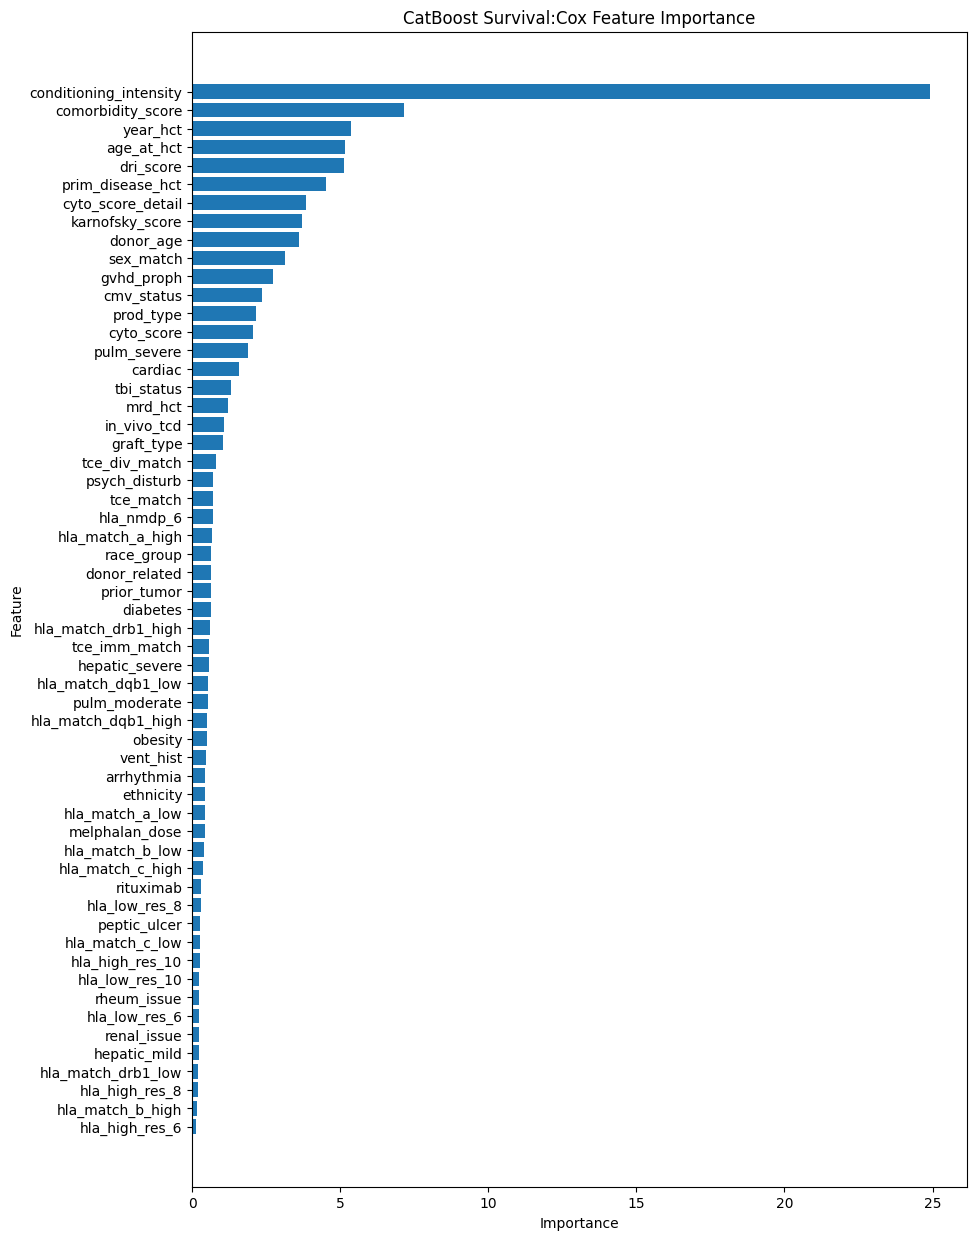

In [26]:
feature_importance = model_cat_cox.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

### アンサンブル (Cox、CV=0.681)

In [27]:
from scipy.stats import rankdata 

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb) + rankdata(oof_cat) + rankdata(oof_lgb)\
                     + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6808771590189345


In [28]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")

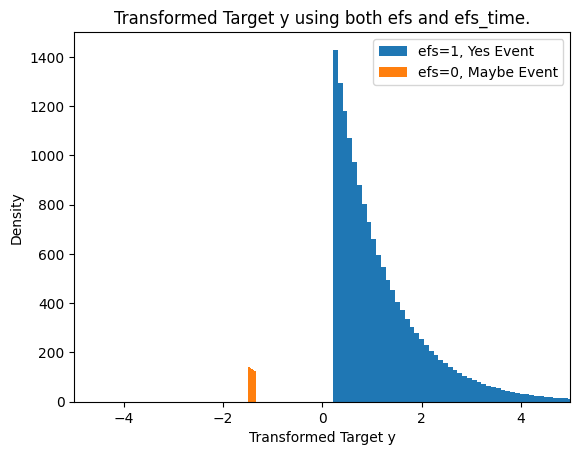

In [29]:
# 死亡者の寿命を最大・最小化して再スケーリング
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()

# 生存者に大きな値を与えることで分離
train.loc[train.efs==0,"y"] += 2*len(train)
# 正規化
train.y = train.y / train.y.max()
# スケール縮小
train.y = np.log(train.y )
# ゼロ平均
train.y -= train.y.mean()
# 反転
train.y *= -1.0

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlim((-5,5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [30]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [31]:
CATS = []
# カテゴリ変数
for c in FEATURES:
    # オブジェクトの場合
    if train[c].dtype=="object":
        # NANで埋める
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        CATS.append(c)
    # ageで無い場合
    elif not "age" in c:
        # 文字型に変換
        train[c] = train[c].astype("str")
        test[c] = test[c].astype("str")
        CATS.append(c)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [32]:
CAT_SIZE = [] # ユニーク数
CAT_EMB = [] # カテゴリ列の圧縮次元数
NUMS = [] # 特徴量の種類数

# 訓練・テストデータ結合
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

print("カテゴリ変数をラベルエンコードする: ")

for c in FEATURES:
    # カテゴリ変数の場合
    if c in CATS:
        combined[c],_ = combined[c].factorize() # ラベルエンコード
        combined[c] -= combined[c].min() # 最小値で引く
        combined[c] = combined[c].astype("int32") # 変換
        #combined[c] = combined[c].astype("category")

        n = combined[c].nunique() # ユニーク数
        mn = combined[c].min() # 最小値
        mx = combined[c].max() # 最大値
        print(f'{c} has ({n}) unique values')

        CAT_SIZE.append(mx+1) # ユニーク数 + 1
        # カテゴリの次元圧縮
        CAT_EMB.append( int(np.ceil( np.sqrt(mx+1))) )

    # 数値変数の場合
    else:
        # メモリを節約する
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
            
        m = combined[c].mean() # 平均
        s = combined[c].std()  # 標準偏差
        combined[c] = (combined[c]-m)/s    # 各行を標準化
        combined[c] = combined[c].fillna(0) # 各行を0で補完
        
        NUMS.append(c)
        
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

カテゴリ変数をラベルエンコードする: 
dri_score has (12) unique values
psych_disturb has (4) unique values
cyto_score has (8) unique values
diabetes has (4) unique values
hla_match_c_high has (4) unique values
hla_high_res_8 has (8) unique values
tbi_status has (8) unique values
arrhythmia has (4) unique values
hla_low_res_6 has (6) unique values
graft_type has (2) unique values
vent_hist has (3) unique values
renal_issue has (4) unique values
pulm_severe has (4) unique values
prim_disease_hct has (18) unique values
hla_high_res_6 has (7) unique values
cmv_status has (5) unique values
hla_high_res_10 has (9) unique values
hla_match_dqb1_high has (4) unique values
tce_imm_match has (9) unique values
hla_nmdp_6 has (6) unique values
hla_match_c_low has (4) unique values
rituximab has (3) unique values
hla_match_drb1_low has (3) unique values
hla_match_dqb1_low has (4) unique values
prod_type has (2) unique values
cyto_score_detail has (6) unique values
conditioning_intensity has (7) unique values
ethnicit

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

In [34]:
class SurvivalModel(nn.Module):
    def __init__(self, cat_sizes, cat_emb_sizes, num_features):
        super(SurvivalModel, self).__init__()
        # 各カテゴリのユニーク数を次元圧縮する
        self.embeddings = nn.ModuleList([nn.Embedding(size, emb_size) 
                                         for size, emb_size in zip(cat_sizes, cat_emb_sizes)])
        # 数値列の数
        self.num_features = num_features
        # 数値列の数 + 各カテゴリの埋め込みユニーク数合計
        total_emb_size = sum(cat_emb_sizes) + num_features

        # 元のコード
        # self.fc1 = nn.Linear(total_emb_size, 256) # input → 256
        # self.fc2 = nn.Linear(256, 256) # 256 → 256
        # self.fc3 = nn.Linear(256, 1) # 256 → 1

        # 少し修正を加え改善
        self.fc1 = nn.Linear(total_emb_size, 256)
        self.bn1 = nn.BatchNorm1d(256, track_running_stats=True)
        self.fc2 = nn.Linear(256, 50)
        self.fc3 = nn.Linear(50, 1)
    
    def forward(self, x_cat, x_num):
        # 各行を次元圧縮エンコードする
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        # 列方向に結合する
        x = torch.cat(embs + [x_num], dim=1)
        # 元のコード
        # x = torch.relu(self.fc1(x)) # 256列
        # x = torch.relu(self.fc2(x)) # 256列

        # 少し修正を加え改善
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.fc2(x))
        
        # return self.fc3(x) # 出力
        return self.fc3(x) # 出力

In [35]:
# K Fold学習
def train_model(model, train_loader, valid_loader, optimizer, criterion, device, epochs):
    for epoch in range(epochs):
        # 訓練モード
        model.train()
        for x_cat, x_num, y in train_loader:
            x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device) # GPU仕様
            optimizer.zero_grad() # 勾配初期化
            output = model(x_cat, x_num)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for x_cat, x_num, y in valid_loader:
                x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
                output = model(x_cat, x_num)
                valid_loss += criterion(output, y).item()
        print(f"Epoch {epoch+1}, Validation Loss: {valid_loss/len(valid_loader)}")

In [36]:
# cudaセッティング
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [37]:
EPOCHS = 4  # エポック数
REPEATS = 3 # 繰り返し計算数
FOLDS = 5   # 分割数
kf = KFold(n_splits=FOLDS, random_state=42, shuffle=True)

oof_nn = np.zeros(len(train)) # 検証結果
pred_nn = np.zeros(len(test)) # テスト結果

for r in range(REPEATS):
    print(f"### REPEAT {r+1} ###")

    # K分割
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        print(f"### Fold {i+1} ###")

        # 訓練データ
        X_train_cats = torch.tensor(train.loc[train_index, CATS].values, dtype=torch.long) # カテゴリ列
        X_train_nums = torch.tensor(train.loc[train_index, NUMS].values, dtype=torch.float32) # 数値列
        y_train = torch.tensor(train.loc[train_index, "y"].values, dtype=torch.float32).unsqueeze(1) # 結合

        # 検証データ
        X_valid_cats = torch.tensor(train.loc[test_index, CATS].values, dtype=torch.long) # カテゴリ列
        X_valid_nums = torch.tensor(train.loc[test_index, NUMS].values, dtype=torch.float32) # 数値列
        y_valid = torch.tensor(train.loc[test_index, "y"].values, dtype=torch.float32).unsqueeze(1) # 結合

        # テンソルデータセット
        train_dataset = TensorDataset(X_train_cats, X_train_nums, y_train)
        valid_dataset = TensorDataset(X_valid_cats, X_valid_nums, y_valid)

        # データローダー
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=512)

        model = SurvivalModel(CAT_SIZE, CAT_EMB, len(NUMS)).to(device) # モデル定義
        optimizer = optim.Adam(model.parameters(), lr=0.001) # 学習アルゴリズム
        criterion = nn.MSELoss() # 平均二乗誤差

        # 学習フェーズ
        train_model(model, train_loader, valid_loader, optimizer, criterion, device, EPOCHS)

        # 予測フェーズ
        model.eval()
        #ここから見直す
        with torch.no_grad():
            # 検証結果
            oof_nn[test_index] += model(X_valid_cats.to(device), X_valid_nums.to(device)).cpu().numpy().flatten()

        X_test_cats = torch.tensor(test[CATS].values, dtype=torch.long) # カテゴリ列
        X_test_nums = torch.tensor(test[NUMS].values, dtype=torch.float32) # 数値列
        with torch.no_grad():
            # テスト結果
            pred_nn += model(X_test_cats.to(device), X_test_nums.to(device)).cpu().numpy().flatten()

# 平均
oof_nn /= REPEATS
pred_nn /= (FOLDS * REPEATS)

### REPEAT 1 ###
### Fold 1 ###
Epoch 1, Validation Loss: 1.973885029554367
Epoch 2, Validation Loss: 1.9610520402590434
Epoch 3, Validation Loss: 1.9397909740606945
Epoch 4, Validation Loss: 1.9331883589426677
### Fold 2 ###
Epoch 1, Validation Loss: 1.9229242006937664
Epoch 2, Validation Loss: 1.8641998370488484
Epoch 3, Validation Loss: 1.889358639717102
Epoch 4, Validation Loss: 1.8475055396556854
### Fold 3 ###
Epoch 1, Validation Loss: 1.9773252308368683
Epoch 2, Validation Loss: 1.9338637987772624
Epoch 3, Validation Loss: 1.9095739722251892
Epoch 4, Validation Loss: 1.93763867020607
### Fold 4 ###
Epoch 1, Validation Loss: 1.9856949647267659
Epoch 2, Validation Loss: 1.9541415472825368
Epoch 3, Validation Loss: 1.9577034612496693
Epoch 4, Validation Loss: 1.9528058469295502
### Fold 5 ###
Epoch 1, Validation Loss: 1.9675994912783306
Epoch 2, Validation Loss: 1.9539571106433868
Epoch 3, Validation Loss: 1.9458301067352295
Epoch 4, Validation Loss: 1.9074723422527313
### REPEAT 2

In [38]:
# スコア計算
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_nn
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for NN =",m)


Overall CV for NN = 0.6678612534755117


In [39]:
from scipy.stats import rankdata 

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb) + rankdata(oof_cat) + rankdata(oof_lgb)\
                     + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox) + rankdata(oof_nn)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)


Overall CV for Ensemble = 0.6811158304109385


# Create Submission CSV

In [40]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_xgb) + rankdata(pred_cat) + rankdata(pred_lgb)\
                     + rankdata(pred_xgb_cox) + rankdata(pred_cat_cox)\
                    + rankdata(pred_nn)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,12.0
1,28801,18.0
2,28802,6.0
